#### train

In [3]:
!export CUDA_VISIBLE_DEVICES=0

%cd /data/codes/apa/train/
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import numpy as np
import pickle
import json
import re
import os

from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torch import nn
import torch

from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    ConfusionMatrixDisplay
)

from src.dataset import PrepDataset
from src.model import PrepModel
from src.utils.train import (
    load_data,
    convert_score_to_color,
    to_device,
    valid_phn,
    valid_utt,
    valid_wrd,
    to_cpu,
    load_pred_and_label,
    save_confusion_matrix_figure,
    validate,
    save
)


/data/codes/apa/train


In [4]:
ckpt_dir = '/data/codes/apa/train/exp/ckpts/dev'
in_dir = "/data/codes/apa/train/data/feats/train/train-data-type-12"
out_dir = f'{in_dir}-filtered'

if not os.path.exists(out_dir):
    os.mkdir(out_dir)

In [5]:
ids, phone_ids, word_ids, phone_scores, word_scores, sentence_scores, durations, \
    gops, relative_positions, wavlm_features_path = load_data(in_dir)

dataset = PrepDataset(
    ids=ids, 
    phone_ids=phone_ids, 
    word_ids=word_ids, 
    phone_scores=phone_scores, 
    word_scores=word_scores,
    sentence_scores=sentence_scores, 
    durations=durations, 
    gops=gops, 
    relative_positions=relative_positions, 
    wavlm_features_path=wavlm_features_path)

dataloader = DataLoader(
    dataset, 
    batch_size=8, 
    num_workers=1,
    shuffle=True, 
    drop_last=True, 
    pin_memory=True, 
)

for i in tqdm(range(len(dataset))):
    batch = dataset[i]
    pass

100%|██████████| 81277/81277 [00:09<00:00, 8426.49it/s]


In [4]:
embed_dim=32
num_heads=1
depth=3
input_dim=855
num_phone=44
max_length=128

lr=1e-3
weight_decay=5e-7
betas=(0.95, 0.999)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

gopt_model = PrepModel(
    embed_dim=embed_dim, num_heads=num_heads, 
    depth=depth, input_dim=input_dim, 
    max_length=max_length, num_phone=num_phone, dropout=0.1).to(device)

trainables = [p for p in gopt_model.parameters() if p.requires_grad]

optimizer = torch.optim.Adam(
    trainables, lr, 
    weight_decay=weight_decay, 
    betas=betas
)

loss_fn = nn.MSELoss()

In [5]:
def calculate_losses(phone_preds, phone_labels, word_preds, word_labels, utterance_preds, utterance_labels):
    # phone level
    mask = phone_labels >=0
    phone_preds = phone_preds.squeeze(2) * mask
    phone_labels = phone_labels * mask
    
    loss_phn = loss_fn(phone_preds, phone_labels)
    loss_phn = loss_phn * (mask.shape[0] * mask.shape[1]) / torch.sum(mask)

    # word level
    mask = word_labels >= 0      
    word_preds = word_preds.squeeze(2) * mask
    word_labels = word_labels * mask
    
    loss_word = loss_fn(word_preds, word_labels)
    loss_word = loss_word * (mask.shape[0] * mask.shape[1]) / torch.sum(mask)

    # utterance level
    loss_utt = loss_fn(utterance_preds.squeeze(1) ,utterance_labels)

    return loss_phn, loss_utt, loss_word

Training: 100%|██████████| 10159/10159 [00:48<00:00, 207.76it/s, loss=0.299, loss_phn=0.201, loss_utt=0.0616, loss_word=0.0356, lr=0.001]  


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.92      0.83      0.87    462840
         1.0       0.18      0.54      0.27     51045
         2.0       0.79      0.36      0.49    100203

    accuracy                           0.72    614088
   macro avg       0.63      0.57      0.54    614088
weighted avg       0.84      0.72      0.76    614088

Save state dict and result to /data/codes/apa/train/exp/ckpts/dev/ckpts-eph=0-mse=0.23569999635219574
### Validation result (epoch=0)
  Phone level:  MSE=0.236  MAE=0.297  PCC=0.700 
   Word level:  MSE=0.097  MAE=0.238  PCC=0.708 
    Utt level:  MSE=0.066  MAE=0.199  PCC=0.739 


Training: 100%|██████████| 10159/10159 [00:48<00:00, 208.99it/s, loss=0.344, loss_phn=0.221, loss_utt=0.0512, loss_word=0.071, lr=0.001]   


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.93      0.82      0.87    462837
         1.0       0.18      0.60      0.28     51044
         2.0       0.85      0.31      0.45    100198

    accuracy                           0.72    614079
   macro avg       0.65      0.58      0.54    614079
weighted avg       0.85      0.72      0.76    614079

Save state dict and result to /data/codes/apa/train/exp/ckpts/dev/ckpts-eph=1-mse=0.21780000627040863
### Validation result (epoch=1)
  Phone level:  MSE=0.218  MAE=0.294  PCC=0.731 
   Word level:  MSE=0.090  MAE=0.226  PCC=0.737 
    Utt level:  MSE=0.058  MAE=0.185  PCC=0.769 


Training: 100%|██████████| 10159/10159 [00:44<00:00, 227.07it/s, loss=0.416, loss_phn=0.173, loss_utt=0.114, loss_word=0.129, lr=0.001]     


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.95      0.75      0.84    462842
         1.0       0.18      0.67      0.28     51045
         2.0       0.80      0.46      0.58    100199

    accuracy                           0.69    614086
   macro avg       0.64      0.62      0.56    614086
weighted avg       0.86      0.69      0.75    614086

Save state dict and result to /data/codes/apa/train/exp/ckpts/dev/ckpts-eph=2-mse=0.20270000398159027
### Validation result (epoch=2)
  Phone level:  MSE=0.203  MAE=0.301  PCC=0.748 
   Word level:  MSE=0.088  MAE=0.236  PCC=0.757 
    Utt level:  MSE=0.057  MAE=0.193  PCC=0.784 


Training: 100%|██████████| 10159/10159 [00:44<00:00, 226.73it/s, loss=0.221, loss_phn=0.132, loss_utt=0.0414, loss_word=0.0476, lr=0.001]   


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.93      0.83      0.88    462839
         1.0       0.20      0.52      0.28     51048
         2.0       0.77      0.52      0.62    100198

    accuracy                           0.75    614085
   macro avg       0.63      0.62      0.59    614085
weighted avg       0.85      0.75      0.79    614085

Save state dict and result to /data/codes/apa/train/exp/ckpts/dev/ckpts-eph=3-mse=0.19939999282360077
### Validation result (epoch=3)
  Phone level:  MSE=0.199  MAE=0.266  PCC=0.754 
   Word level:  MSE=0.080  MAE=0.205  PCC=0.760 
    Utt level:  MSE=0.051  MAE=0.172  PCC=0.789 


Training: 100%|██████████| 10159/10159 [00:51<00:00, 197.52it/s, loss=0.221, loss_phn=0.192, loss_utt=0.0141, loss_word=0.0157, lr=0.001]   


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.94      0.81      0.87    462846
         1.0       0.20      0.62      0.30     51047
         2.0       0.83      0.45      0.58    100199

    accuracy                           0.74    614092
   macro avg       0.66      0.63      0.58    614092
weighted avg       0.86      0.74      0.78    614092

Save state dict and result to /data/codes/apa/train/exp/ckpts/dev/ckpts-eph=4-mse=0.18729999661445618
### Validation result (epoch=4)
  Phone level:  MSE=0.187  MAE=0.276  PCC=0.769 
   Word level:  MSE=0.077  MAE=0.212  PCC=0.775 
    Utt level:  MSE=0.049  MAE=0.174  PCC=0.801 


Training: 100%|██████████| 10159/10159 [00:45<00:00, 223.04it/s, loss=0.348, loss_phn=0.238, loss_utt=0.0502, loss_word=0.0603, lr=0.001]   


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.94      0.81      0.87    462841
         1.0       0.20      0.61      0.30     51046
         2.0       0.83      0.46      0.59    100199

    accuracy                           0.74    614086
   macro avg       0.66      0.63      0.59    614086
weighted avg       0.86      0.74      0.78    614086

Save state dict and result to /data/codes/apa/train/exp/ckpts/dev/ckpts-eph=5-mse=0.186599999666214
### Validation result (epoch=5)
  Phone level:  MSE=0.187  MAE=0.273  PCC=0.769 
   Word level:  MSE=0.077  MAE=0.206  PCC=0.777 
    Utt level:  MSE=0.051  MAE=0.171  PCC=0.798 


Training: 100%|██████████| 10159/10159 [00:45<00:00, 224.02it/s, loss=0.241, loss_phn=0.161, loss_utt=0.0377, loss_word=0.0423, lr=0.001]   


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.95      0.81      0.87    462818
         1.0       0.20      0.62      0.30     51042
         2.0       0.82      0.48      0.61    100199

    accuracy                           0.74    614059
   macro avg       0.66      0.64      0.59    614059
weighted avg       0.86      0.74      0.78    614059

Save state dict and result to /data/codes/apa/train/exp/ckpts/dev/ckpts-eph=6-mse=0.18240000307559967
### Validation result (epoch=6)
  Phone level:  MSE=0.182  MAE=0.269  PCC=0.775 
   Word level:  MSE=0.075  MAE=0.199  PCC=0.776 
    Utt level:  MSE=0.049  MAE=0.165  PCC=0.807 


Training: 100%|██████████| 10159/10159 [00:44<00:00, 226.08it/s, loss=0.335, loss_phn=0.18, loss_utt=0.0722, loss_word=0.0836, lr=0.001]    


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.95      0.78      0.86    462837
         1.0       0.19      0.66      0.30     51045
         2.0       0.84      0.47      0.60    100196

    accuracy                           0.72    614078
   macro avg       0.66      0.64      0.59    614078
weighted avg       0.87      0.72      0.77    614078

Save state dict and result to /data/codes/apa/train/exp/ckpts/dev/ckpts-eph=7-mse=0.18129999935626984
### Validation result (epoch=7)
  Phone level:  MSE=0.181  MAE=0.281  PCC=0.778 
   Word level:  MSE=0.073  MAE=0.208  PCC=0.787 
    Utt level:  MSE=0.047  MAE=0.170  PCC=0.807 


Training: 100%|██████████| 10159/10159 [00:45<00:00, 223.26it/s, loss=0.261, loss_phn=0.141, loss_utt=0.0493, loss_word=0.0704, lr=0.001]   


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.95      0.79      0.86    462842
         1.0       0.20      0.65      0.30     51048
         2.0       0.83      0.50      0.62    100198

    accuracy                           0.73    614088
   macro avg       0.66      0.65      0.59    614088
weighted avg       0.87      0.73      0.78    614088

Save state dict and result to /data/codes/apa/train/exp/ckpts/dev/ckpts-eph=8-mse=0.17820000648498535
### Validation result (epoch=8)
  Phone level:  MSE=0.178  MAE=0.276  PCC=0.782 
   Word level:  MSE=0.080  MAE=0.224  PCC=0.791 
    Utt level:  MSE=0.053  MAE=0.186  PCC=0.812 


Training: 100%|██████████| 10159/10159 [00:50<00:00, 201.58it/s, loss=0.437, loss_phn=0.179, loss_utt=0.122, loss_word=0.135, lr=0.001]     


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.95      0.79      0.87    462822
         1.0       0.20      0.60      0.30     51049
         2.0       0.79      0.58      0.67    100198

    accuracy                           0.74    614069
   macro avg       0.65      0.66      0.61    614069
weighted avg       0.86      0.74      0.79    614069

Save state dict and result to /data/codes/apa/train/exp/ckpts/dev/ckpts-eph=9-mse=0.17730000615119934
### Validation result (epoch=9)
  Phone level:  MSE=0.177  MAE=0.265  PCC=0.785 
   Word level:  MSE=0.071  MAE=0.198  PCC=0.794 
    Utt level:  MSE=0.049  MAE=0.171  PCC=0.816 


Training: 100%|██████████| 10159/10159 [01:10<00:00, 143.81it/s, loss=0.277, loss_phn=0.154, loss_utt=0.0434, loss_word=0.0796, lr=0.001]   


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.94      0.86      0.90    462841
         1.0       0.22      0.54      0.31     51043
         2.0       0.83      0.51      0.63    100197

    accuracy                           0.78    614081
   macro avg       0.66      0.64      0.61    614081
weighted avg       0.86      0.78      0.80    614081

Save state dict and result to /data/codes/apa/train/exp/ckpts/dev/ckpts-eph=10-mse=0.17499999701976776
### Validation result (epoch=10)
  Phone level:  MSE=0.175  MAE=0.244  PCC=0.787 
   Word level:  MSE=0.070  MAE=0.191  PCC=0.797 
    Utt level:  MSE=0.046  MAE=0.161  PCC=0.820 


Training: 100%|██████████| 10159/10159 [00:46<00:00, 219.51it/s, loss=0.431, loss_phn=0.241, loss_utt=0.0896, loss_word=0.101, lr=0.001]    


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.94      0.83      0.89    462838
         1.0       0.21      0.56      0.31     51048
         2.0       0.81      0.56      0.66    100194

    accuracy                           0.77    614080
   macro avg       0.65      0.65      0.62    614080
weighted avg       0.86      0.77      0.80    614080

Save state dict and result to /data/codes/apa/train/exp/ckpts/dev/ckpts-eph=11-mse=0.17080000042915344
### Validation result (epoch=11)
  Phone level:  MSE=0.171  MAE=0.251  PCC=0.792 
   Word level:  MSE=0.066  MAE=0.186  PCC=0.804 
    Utt level:  MSE=0.044  MAE=0.159  PCC=0.826 


Training: 100%|██████████| 10159/10159 [00:46<00:00, 220.36it/s, loss=0.342, loss_phn=0.168, loss_utt=0.0828, loss_word=0.091, lr=0.0008]     


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.95      0.83      0.89    462823
         1.0       0.21      0.60      0.32     51046
         2.0       0.84      0.51      0.64    100199

    accuracy                           0.76    614068
   macro avg       0.67      0.65      0.61    614068
weighted avg       0.87      0.76      0.80    614068

Save state dict and result to /data/codes/apa/train/exp/ckpts/dev/ckpts-eph=12-mse=0.16590000689029694
### Validation result (epoch=12)
  Phone level:  MSE=0.166  MAE=0.246  PCC=0.798 
   Word level:  MSE=0.066  MAE=0.186  PCC=0.809 
    Utt level:  MSE=0.043  MAE=0.157  PCC=0.828 


Training: 100%|██████████| 10159/10159 [00:45<00:00, 222.13it/s, loss=0.132, loss_phn=0.0816, loss_utt=0.0205, loss_word=0.0296, lr=0.0008]  


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.95      0.82      0.88    462842
         1.0       0.21      0.62      0.31     51043
         2.0       0.83      0.55      0.66    100196

    accuracy                           0.76    614081
   macro avg       0.66      0.66      0.62    614081
weighted avg       0.87      0.76      0.80    614081

Save state dict and result to /data/codes/apa/train/exp/ckpts/dev/ckpts-eph=13-mse=0.163100004196167
### Validation result (epoch=13)
  Phone level:  MSE=0.163  MAE=0.253  PCC=0.802 
   Word level:  MSE=0.064  MAE=0.185  PCC=0.814 
    Utt level:  MSE=0.041  MAE=0.156  PCC=0.835 


Training: 100%|██████████| 10159/10159 [00:46<00:00, 220.01it/s, loss=0.162, loss_phn=0.132, loss_utt=0.014, loss_word=0.0164, lr=0.0008]    


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.95      0.83      0.88    462834
         1.0       0.21      0.61      0.32     51041
         2.0       0.83      0.56      0.67    100190

    accuracy                           0.76    614065
   macro avg       0.66      0.66      0.62    614065
weighted avg       0.87      0.76      0.80    614065

Save state dict and result to /data/codes/apa/train/exp/ckpts/dev/ckpts-eph=14-mse=0.16060000658035278
### Validation result (epoch=14)
  Phone level:  MSE=0.161  MAE=0.242  PCC=0.805 
   Word level:  MSE=0.062  MAE=0.177  PCC=0.820 
    Utt level:  MSE=0.040  MAE=0.151  PCC=0.841 


Training: 100%|██████████| 10159/10159 [00:45<00:00, 223.80it/s, loss=0.332, loss_phn=0.232, loss_utt=0.0491, loss_word=0.0513, lr=0.00064]   


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.95      0.85      0.89    462825
         1.0       0.22      0.60      0.32     51046
         2.0       0.85      0.51      0.64    100196

    accuracy                           0.77    614067
   macro avg       0.67      0.65      0.62    614067
weighted avg       0.87      0.77      0.80    614067

Save state dict and result to /data/codes/apa/train/exp/ckpts/dev/ckpts-eph=15-mse=0.1606999933719635
### Validation result (epoch=15)
  Phone level:  MSE=0.161  MAE=0.239  PCC=0.806 
   Word level:  MSE=0.062  MAE=0.175  PCC=0.822 
    Utt level:  MSE=0.040  MAE=0.147  PCC=0.845 


Training: 100%|██████████| 10159/10159 [00:45<00:00, 221.20it/s, loss=0.208, loss_phn=0.0922, loss_utt=0.047, loss_word=0.0692, lr=0.00064]   


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.95      0.85      0.90    462834
         1.0       0.22      0.59      0.32     51044
         2.0       0.85      0.53      0.65    100195

    accuracy                           0.78    614073
   macro avg       0.67      0.66      0.62    614073
weighted avg       0.87      0.78      0.81    614073

Save state dict and result to /data/codes/apa/train/exp/ckpts/dev/ckpts-eph=16-mse=0.15850000083446503
### Validation result (epoch=16)
  Phone level:  MSE=0.159  MAE=0.238  PCC=0.809 
   Word level:  MSE=0.060  MAE=0.179  PCC=0.826 
    Utt level:  MSE=0.039  MAE=0.147  PCC=0.844 


Training: 100%|██████████| 10159/10159 [01:00<00:00, 167.26it/s, loss=0.204, loss_phn=0.148, loss_utt=0.0223, loss_word=0.0341, lr=0.00064]   


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.95      0.84      0.89    462827
         1.0       0.22      0.60      0.32     51045
         2.0       0.84      0.54      0.66    100196

    accuracy                           0.77    614068
   macro avg       0.67      0.66      0.62    614068
weighted avg       0.87      0.77      0.80    614068

Save state dict and result to /data/codes/apa/train/exp/ckpts/dev/ckpts-eph=17-mse=0.15940000116825104
### Validation result (epoch=17)
  Phone level:  MSE=0.159  MAE=0.241  PCC=0.807 
   Word level:  MSE=0.063  MAE=0.179  PCC=0.822 
    Utt level:  MSE=0.039  MAE=0.148  PCC=0.848 


Training: 100%|██████████| 10159/10159 [01:06<00:00, 151.71it/s, loss=0.252, loss_phn=0.165, loss_utt=0.045, loss_word=0.0419, lr=0.000512]    


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.95      0.84      0.89    462840
         1.0       0.22      0.61      0.32     51048
         2.0       0.85      0.53      0.65    100202

    accuracy                           0.77    614090
   macro avg       0.67      0.66      0.62    614090
weighted avg       0.87      0.77      0.80    614090

Save state dict and result to /data/codes/apa/train/exp/ckpts/dev/ckpts-eph=18-mse=0.15680000185966492
### Validation result (epoch=18)
  Phone level:  MSE=0.157  MAE=0.242  PCC=0.811 
   Word level:  MSE=0.060  MAE=0.177  PCC=0.828 
    Utt level:  MSE=0.038  MAE=0.147  PCC=0.852 


Training: 100%|██████████| 10159/10159 [00:46<00:00, 217.08it/s, loss=0.2, loss_phn=0.114, loss_utt=0.0312, loss_word=0.055, lr=0.000512]       


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.96      0.81      0.88    462837
         1.0       0.21      0.60      0.31     51048
         2.0       0.82      0.60      0.69    100200

    accuracy                           0.76    614085
   macro avg       0.66      0.67      0.63    614085
weighted avg       0.87      0.76      0.80    614085

Save state dict and result to /data/codes/apa/train/exp/ckpts/dev/ckpts-eph=19-mse=0.15629999339580536
### Validation result (epoch=19)
  Phone level:  MSE=0.156  MAE=0.243  PCC=0.812 
   Word level:  MSE=0.058  MAE=0.175  PCC=0.833 
    Utt level:  MSE=0.037  MAE=0.146  PCC=0.857 


Training: 100%|██████████| 10159/10159 [00:46<00:00, 219.72it/s, loss=0.0664, loss_phn=0.0426, loss_utt=0.012, loss_word=0.0119, lr=0.000512]   


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.95      0.85      0.90    462833
         1.0       0.22      0.60      0.33     51047
         2.0       0.86      0.54      0.66    100195

    accuracy                           0.78    614075
   macro avg       0.68      0.66      0.63    614075
weighted avg       0.87      0.78      0.81    614075

Save state dict and result to /data/codes/apa/train/exp/ckpts/dev/ckpts-eph=20-mse=0.15369999408721924
### Validation result (epoch=20)
  Phone level:  MSE=0.154  MAE=0.241  PCC=0.815 
   Word level:  MSE=0.057  MAE=0.172  PCC=0.835 
    Utt level:  MSE=0.036  MAE=0.141  PCC=0.856 


Training: 100%|██████████| 10159/10159 [00:46<00:00, 220.52it/s, loss=0.285, loss_phn=0.132, loss_utt=0.0797, loss_word=0.0729, lr=0.00041]   


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.96      0.80      0.87    462832
         1.0       0.21      0.64      0.32     51049
         2.0       0.83      0.59      0.69    100200

    accuracy                           0.76    614081
   macro avg       0.67      0.68      0.63    614081
weighted avg       0.88      0.76      0.80    614081

Save state dict and result to /data/codes/apa/train/exp/ckpts/dev/ckpts-eph=21-mse=0.15189999341964722
### Validation result (epoch=21)
  Phone level:  MSE=0.152  MAE=0.247  PCC=0.819 
   Word level:  MSE=0.059  MAE=0.186  PCC=0.842 
    Utt level:  MSE=0.038  MAE=0.153  PCC=0.865 


Training: 100%|██████████| 10159/10159 [00:46<00:00, 220.56it/s, loss=0.212, loss_phn=0.161, loss_utt=0.0197, loss_word=0.0316, lr=0.00041]   


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.95      0.84      0.89    462842
         1.0       0.22      0.62      0.33     51045
         2.0       0.85      0.56      0.67    100199

    accuracy                           0.77    614086
   macro avg       0.68      0.67      0.63    614086
weighted avg       0.87      0.77      0.81    614086

Save state dict and result to /data/codes/apa/train/exp/ckpts/dev/ckpts-eph=22-mse=0.15000000596046448
### Validation result (epoch=22)
  Phone level:  MSE=0.150  MAE=0.240  PCC=0.820 
   Word level:  MSE=0.055  MAE=0.168  PCC=0.842 
    Utt level:  MSE=0.036  MAE=0.145  PCC=0.861 


Training: 100%|██████████| 10159/10159 [00:46<00:00, 218.31it/s, loss=0.185, loss_phn=0.149, loss_utt=0.0151, loss_word=0.0208, lr=0.00041]    


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.95      0.84      0.89    462840
         1.0       0.22      0.60      0.33     51045
         2.0       0.84      0.57      0.68    100198

    accuracy                           0.78    614083
   macro avg       0.67      0.67      0.63    614083
weighted avg       0.87      0.78      0.81    614083

Save state dict and result to /data/codes/apa/train/exp/ckpts/dev/ckpts-eph=23-mse=0.14869999885559082
### Validation result (epoch=23)
  Phone level:  MSE=0.149  MAE=0.232  PCC=0.821 
   Word level:  MSE=0.054  MAE=0.168  PCC=0.844 
    Utt level:  MSE=0.035  MAE=0.140  PCC=0.865 


Training: 100%|██████████| 10159/10159 [00:45<00:00, 221.58it/s, loss=0.215, loss_phn=0.166, loss_utt=0.0215, loss_word=0.0279, lr=0.000328]    


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.95      0.84      0.89    462837
         1.0       0.22      0.61      0.33     51046
         2.0       0.85      0.57      0.68    100195

    accuracy                           0.78    614078
   macro avg       0.68      0.67      0.63    614078
weighted avg       0.88      0.78      0.81    614078

Save state dict and result to /data/codes/apa/train/exp/ckpts/dev/ckpts-eph=24-mse=0.14720000326633453
### Validation result (epoch=24)
  Phone level:  MSE=0.147  MAE=0.234  PCC=0.823 
   Word level:  MSE=0.053  MAE=0.169  PCC=0.850 
    Utt level:  MSE=0.033  MAE=0.139  PCC=0.872 


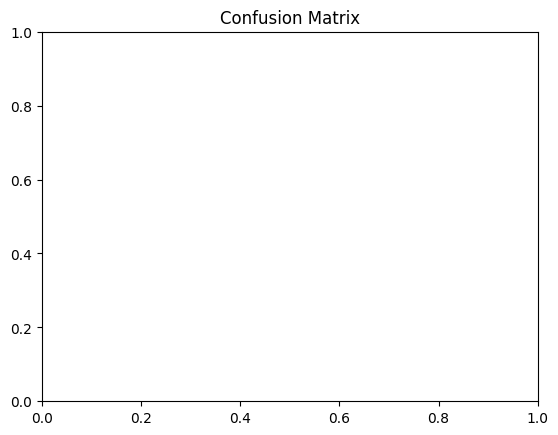

In [6]:
global_step = 0
best_mse = 1e5
num_epoch = 25 
phone_weight = 1.0
word_weight = 1.0
utterance_weight = 1.0

cur_lr = lr
for epoch in range(num_epoch):
    if epoch >= 10 and epoch % 3 == 0:
        cur_lr = (4 / 5) * cur_lr 
        for param_group in optimizer.param_groups:
            param_group['lr'] = cur_lr

    gopt_model.train()
    train_tqdm = tqdm(dataloader, "Training")
    for batch in train_tqdm:
        optimizer.zero_grad()

        ids, features, phone_ids, word_ids, relative_positions,\
            phone_labels, word_labels, utterance_labels = to_device(batch, device)
        
        utterance_preds, phone_preds, word_preds = gopt_model(
            x=features.float(), phn=phone_ids.long(), rel_pos=relative_positions.long())
                
        loss_phn, loss_utt, loss_word = calculate_losses(
            phone_preds=phone_preds, 
            phone_labels=phone_labels, 
            word_preds=word_preds, 
            word_labels=word_labels, 
            utterance_preds=utterance_preds, 
            utterance_labels=utterance_labels)

        loss = phone_weight*loss_phn + word_weight*loss_word + utterance_weight*loss_utt
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(gopt_model.parameters(), 1.0)
        
        optimizer.step()
        
        global_step += 1
        train_tqdm.set_postfix(
            lr=cur_lr,
            loss=loss.item(), 
            loss_phn=loss_phn.item(), 
            loss_word=loss_word.item(), 
            loss_utt=loss_utt.item())
    
    valid_result = validate(
        epoch=epoch, 
        device=device,
        optimizer=optimizer,
        gopt_model=gopt_model, 
        testloader=dataloader, 
        best_mse=best_mse, 
        ckpt_dir=ckpt_dir)
    
    best_mse = valid_result["best_mse"]
    global_step += 1

#### infer

In [7]:
!export CUDA_VISIBLE_DEVICES=0

import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import numpy as np
import pickle
import torch
import json
import re
import os

from torch.utils.data import Dataset, DataLoader
from torch import nn

from src.utils.train import (
    to_device,
    load_data,
    load_id
)

In [8]:
ckpt_dir = '/data/codes/apa/train/exp/dev'

ids, phone_ids, word_ids, phone_scores, word_scores, sentence_scores, durations, \
    gops, relative_positions, wavlm_features_path = load_data(in_dir)

dataset = PrepDataset(
    ids, phone_ids, word_ids, 
    phone_scores, word_scores, sentence_scores, 
    durations, gops, relative_positions, wavlm_features_path)

dataloader = DataLoader(
    dataset, 
    batch_size=1, 
    num_workers=1,
    shuffle=True, 
    drop_last=False, 
    pin_memory=True, 
)

In [9]:
# embed_dim=32
# num_heads=1
# depth=3
# input_dim=855
# num_phone=44
# max_length=128

# lr=1e-3
# weight_decay=5e-7
# betas=(0.95, 0.999)

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# gopt_model = PrepModel(
#     embed_dim=embed_dim, num_heads=num_heads, 
#     depth=depth, input_dim=input_dim, 
#     max_length=max_length, num_phone=num_phone, dropout=0.1).to(device)

In [10]:
# ckpt_path = "/data/codes/apa/train/exp/dev/ckpts-eph=25-mse=0.147599995136261/model.pt"
# state_dict = torch.load(ckpt_path, map_location="cpu")
# gopt_model.eval()
# gopt_model.load_state_dict(state_dict)

In [11]:
sample_ids = []
prep_scores = []
elsa_scores = []

gopt_model.eval()
for batch in tqdm(dataloader):
    batch_ids, features, phone_ids, word_ids, relative_positions,\
        phone_labels, word_labels, utterance_labels = to_device(batch, device)
    
    with torch.no_grad():
        phone_score = gopt_model.forwar_phn(
            x=features.float(), phn=phone_ids.long())
        
        phone_score = phone_score.squeeze(-1)
        
    assert phone_score.shape[0] == 1
    
    phone_ids = [f'{batch_ids[0]}_{index}' for index in range((phone_labels!=-1).sum())]
    sample_ids += phone_ids

    elsa_scores.append(phone_labels[phone_labels!=-1])
    prep_scores.append(phone_score[phone_labels!=-1])

elsa_scores = torch.concat(elsa_scores).cpu()
prep_scores = torch.concat(prep_scores).cpu()

100%|██████████| 81277/81277 [01:44<00:00, 780.60it/s] 


In [12]:
with open(f'{in_dir}/id', "w") as f:
    content = "\n".join(sample_ids)
    f.write(content)

np.save(f'{in_dir}/infer-prep_scores.npy', prep_scores.numpy() * 50)
np.save(f'{in_dir}/infer-elsa_scores.npy', elsa_scores.numpy() * 50)
np.save(f'{in_dir}/infer-phone_ids.npy', sample_ids)

#### filter

In [27]:
%cd /data/codes/apa/train

from sklearn.metrics import classification_report
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch

from src.utils.train import (
    convert_score_to_color
)

/data/codes/apa/train


In [28]:
prep_scores = np.load(f'{in_dir}/infer-prep_scores.npy')
elsa_scores = np.load(f'{in_dir}/infer-elsa_scores.npy')
ids = np.load(f'{in_dir}/infer-phone_ids.npy')

In [29]:
prep_decisions = convert_score_to_color(torch.from_numpy(prep_scores).clone())
prep_decisions = prep_decisions.int().numpy()

elsa_decisions = convert_score_to_color(torch.from_numpy(elsa_scores).clone())
elsa_decisions = elsa_decisions.int().numpy()

print(classification_report(y_true=elsa_decisions, y_pred=prep_decisions))

              precision    recall  f1-score   support

           0       0.93      1.00      0.96    566712
           1       0.01      0.01      0.01      1196
           2       0.93      0.05      0.10     46208

    accuracy                           0.93    614116
   macro avg       0.62      0.35      0.36    614116
weighted avg       0.93      0.93      0.90    614116



In [30]:
id2label = {0:"GREEN", 1:"YELLOW", 2:"RED"}

df = pd.DataFrame(
    {
        "id": ids.tolist(),
        "prep": prep_decisions.tolist(),
        "elsa": elsa_decisions.tolist(),
        "prep_score": prep_scores.tolist(),
        "elsa_score": elsa_scores.tolist(),
    }
)

df["prep"] = df.prep.apply(lambda x: id2label[x])
df["elsa"] = df.elsa.apply(lambda x: id2label[x])
df["uid"] = df.id.apply(lambda x: x.split("_")[0])
df["diff"] = np.abs(df["prep_score"] - df["elsa_score"])
df.head(2)

,id,prep,elsa,prep_score,elsa_score,uid,diff
0,4638476_2_0,GREEN,GREEN,93.619156,84.0,4638476,9.619156
1,4638476_2_1,GREEN,GREEN,96.730301,99.0,4638476,2.269699


In [36]:
print(df.uid.nunique())
print((df[df["diff"] > 40].uid.value_counts() > 1).sum())

10733
8198


In [32]:
ignore_samples = df[df["diff"] > 30].uid.value_counts() > 1
ignore_samples = ignore_samples[ignore_samples==True]

filtered_samples = df[~df.uid.isin(ignore_samples.index)]
print(df.shape)
print(filtered_samples.shape)

(614116, 7)
(31273, 7)


In [22]:
id_path = f"{out_dir}/id"
with open(id_path, "w", encoding="utf-8") as f:
    f.write("\n".join(filtered_samples.uid.unique().tolist()))

In [23]:
id_path

'/data/codes/apa/train/data/feats/train/train-data-type-12-filtered/id'